In [ ]:
## Notebook env: farnaz_spatial (farnaz_spatial kernel)
## this notebook quantifies and compares the frequency of each cell type across different regions and temperatures

In [1]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
import seaborn as sns

In [2]:
## load in the data

results_folder = '/home/ssobti/projects/farnaz_spatial/output_data/mouse/cell2location/multi_ref_annot'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map/N2_alpha20'

adata_file = f"{run_name}/sp.h5ad"
adata_vis = sc.read_h5ad(adata_file)

In [3]:
adata_vis.obs

in_tissue  array_row  array_col    sample  \
spot_id                                                                  
count-A1_AAACAAGTATCTCCCA-1          1         50        102  count-A1   
count-A1_AAACACCAATAACTGC-1          1         59         19  count-A1   
count-A1_AAACAGCTTTCAGAAG-1          1         43          9  count-A1   
count-A1_AAACAGGGTCTATATT-1          1         47         13  count-A1   
count-A1_AAACAGTGTTCCTGGG-1          1         73         43  count-A1   
...                                ...        ...        ...       ...   
count-D1_TTGTTAGCAAATTCGA-1          1         22         42  count-D1   
count-D1_TTGTTCAGTGTGCTAC-1          1         24         64  count-D1   
count-D1_TTGTTTCACATCCAGG-1          1         58         42  count-D1   
count-D1_TTGTTTCCATACAACT-1          1         45         27  count-D1   
count-D1_TTGTTTGTGTAAATTC-1          1          7         51  count-D1   

                             n_genes_by_counts  log1p_n_genes_by_counts  \
spot_id                                                                   
count-A1_AAACAAGTATCTCCCA-1               3976                 8.288283   
count-A1_AAACACCAATAACTGC-1               4429                 8.396155   
count-A1_AAACAGCTTTCAGAAG-1               1826                 7.510431   
count-A1_AAACAGGGTCTATATT-1               2560                 7.848153   
count-A1_AAACAGTGTTCCTGGG-1               4224                 8.348775   
...                                        ...                      ...   
count-D1_TTGTTAGCAAATTCGA-1               3821                 8.248529   
count-D1_TTGTTCAGTGTGCTAC-1               2552                 7.845024   
count-D1_TTGTTTCACATCCAGG-1                730                 6.594413   
count-D1_TTGTTTCCATACAACT-1               1768                 7.478170   
count-D1_TTGTTTGTGTAAATTC-1               3685                 8.212297   

                             total_counts  log1p_total_counts  \
spot_id                                                         
count-A1_AAACAAGTATCTCCCA-1       10597.0            9.268420   
count-A1_AAACACCAATAACTGC-1       14374.0            9.573246   
count-A1_AAACAGCTTTCAGAAG-1        3311.0            8.105308   
count-A1_AAACAGGGTCTATATT-1        5105.0            8.538172   
count-A1_AAACAGTGTTCCTGGG-1       13278.0            9.493939   
...                                   ...                 ...   
count-D1_TTGTTAGCAAATTCGA-1        8888.0            9.092570   
count-D1_TTGTTCAGTGTGCTAC-1        4844.0            8.485703   
count-D1_TTGTTTCACATCCAGG-1         970.0            6.878326   
count-D1_TTGTTTCCATACAACT-1        3037.0            8.018954   
count-D1_TTGTTTGTGTAAATTC-1        8191.0            9.010913   

                             pct_counts_in_top_50_genes  \
spot_id                                                   
count-A1_AAACAAGTATCTCCCA-1                   22.421440   
count-A1_AAACACCAATAACTGC-1                   24.356477   
count-A1_AAACAGCTTTCAGAAG-1                   23.165207   
count-A1_AAACAGGGTCTATATT-1                   22.683643   
count-A1_AAACAGTGTTCCTGGG-1                   28.212080   
...                                                 ...   
count-D1_TTGTTAGCAAATTCGA-1                   19.723222   
count-D1_TTGTTCAGTGTGCTAC-1                   21.717589   
count-D1_TTGTTTCACATCCAGG-1                   24.948454   
count-D1_TTGTTTCCATACAACT-1                   24.135660   
count-D1_TTGTTTGTGTAAATTC-1                   23.049689   

                             pct_counts_in_top_100_genes  \
spot_id                                                    
count-A1_AAACAAGTATCTCCCA-1                    29.470605   
count-A1_AAACACCAATAACTGC-1                    31.904828   
count-A1_AAACAGCTTTCAGAAG-1                    30.927212   
count-A1_AAACAGGGTCTATATT-1                    29.676787   
count-A1_AAACAGTGTTCCTGGG-1                    34.907366   
...                                                  ...

In [4]:
spot_exp = adata_vis.obsm['q05_cell_abundance_w_sf'].assign(array_row = adata_vis.obs['array_row'], array_col = adata_vis.obs['array_col'], sample = adata_vis.obs['sample'])
spot_exp = spot_exp[np.concatenate([spot_exp.columns[-3:], spot_exp.columns[:-3]])]

spot_exp_dict = {}
for slide in spot_exp['sample'].unique():
    spot_exp_dict[slide] = spot_exp.loc[spot_exp['sample'] == slide, :]


## Honeycomb grid

In [6]:
## get top edge centers
starting_center = np.array([[1,3]])
top_edges_df = pd.DataFrame(columns = ['array_row', 'array_col'])
max_row = 77
max_col = 127
col_center_repeat_int = 14
secondary_shift = 9
starting_center = np.array([1,3])
max_top_intervals = int(max_col/col_center_repeat_int) + 1

for i in range(max_top_intervals):
    top_edges_df = pd.concat([top_edges_df, pd.DataFrame({'array_row': [starting_center[0]], 'array_col': [starting_center[1] + col_center_repeat_int*i]})]).reset_index(drop=True)
    top_edges_df = pd.concat([top_edges_df, pd.DataFrame({'array_row': [starting_center[0] + 1], 'array_col': [starting_center[1] + secondary_shift + col_center_repeat_int*i]})]).reset_index(drop=True)

In [7]:
top_edges_df

array_row array_col
0          1         3
1          2        12
2          1        17
3          2        26
4          1        31
5          2        40
6          1        45
7          2        54
8          1        59
9          2        68
10         1        73
11         2        82
12         1        87
13         2        96
14         1       101
15         2       110
16         1       115
17         2       124
18         1       129
19         2       138

In [8]:
## get left edge centers
starting_center = np.array([[1,3]])
left_edges_df = pd.DataFrame(columns = ['array_row', 'array_col'])
max_row = 77
max_col = 127
row_center_repeat_int = 14
secondary_shift = 5
tertiary_shift = 8
quaternary_shift = 11
starting_center = np.array([1,3])
max_left_intervals = int(max_row/col_center_repeat_int) + 1

for i in range(max_left_intervals):
    left_edges_df = pd.concat([left_edges_df, pd.DataFrame({'array_row': [starting_center[0] + 14*i], 'array_col': [starting_center[1]]})]).reset_index(drop=True)
    left_edges_df = pd.concat([left_edges_df, pd.DataFrame({'array_row': [starting_center[0] + secondary_shift + 14*i], 'array_col': [starting_center[1] + 3]})]).reset_index(drop=True)
    left_edges_df = pd.concat([left_edges_df, pd.DataFrame({'array_row': [starting_center[0] + tertiary_shift + 14*i], 'array_col': [starting_center[1] + 2]})]).reset_index(drop=True)
    left_edges_df = pd.concat([left_edges_df, pd.DataFrame({'array_row': [starting_center[0] + quaternary_shift + 14*i], 'array_col': [starting_center[1] + 1]})]).reset_index(drop=True)

In [9]:
## throw out edges that have center values outside permissible range (rows 0-77, cols 0-127)
top_edges_df = top_edges_df.loc[(top_edges_df['array_row'] <= 77) & (top_edges_df['array_col'] <= 127), :]
left_edges_df = left_edges_df.loc[(left_edges_df['array_row'] <= 77) & (left_edges_df['array_col'] <= 127), :]

In [10]:
def diagonals(row_start, row_max, col_start, col_max):
    row_range = list(range(row_start, row_max + 1, 2))
    col_range = list(range(col_start, col_max + 1, 4))
    return(list(zip(row_range, col_range)))

## get diagonal centers and combine them

diagonal_centers_df = pd.DataFrame(columns = ['array_row', 'array_col'])
top_diagonal_centers = {}
left_diagonal_centers = {}

for index, row in top_edges_df.iterrows():
    top_diagonal_centers['top' + str(index)] = pd.DataFrame(diagonals(row['array_row'], 77, row['array_col'], 127), columns = ['array_row', 'array_col'])

for index, row in left_edges_df.iterrows():
    left_diagonal_centers['left' + str(index)] = pd.DataFrame(diagonals(row['array_row'], 77, row['array_col'], 127), columns = ['array_row', 'array_col'])

centers = top_diagonal_centers | left_diagonal_centers

In [11]:
## combine all centers into one df
centers_concatenated = pd.concat(centers.values()).reset_index(drop = True)
centers_concatenated = centers_concatenated.drop_duplicates(inplace = False).reset_index(drop = True)
centers_concatenated

array_row  array_col
0            1          3
1            3          7
2            5         11
3            7         15
4            9         19
..         ...        ...
682         71          3
683         73          7
684         75         11
685         77         15
686         76          6

[687 rows x 2 columns]

In [12]:
## throw out hexagon centers that don't have all 6 neighbors within permissible range (rows 0-77, cols 0-127)
## calculate all 6 neighbor coordinates for each center
## remember these neighbor hold for all the slides since the slide hex pattern is the same
def hex_neighbors(center):
    center = np.array(center)
    n1 = [center[0] - 1, center[1] - 1]
    n2 = [center[0], center[1] - 2]
    n3 = [center[0] - 1, center[1] + 1]
    n4 = [center[0] + 1, center[1] + 1]
    n5 = [center[0], center[1] + 2]
    n6 = [center[0] + 1, center[1] - 1]
    return(np.array([center, n1, n2, n3, n4, n5, n6]))

neighbors = centers_concatenated.apply(hex_neighbors, axis = 1)
filtered_centers = pd.DataFrame(columns = ['array_row', 'array_col'])

for index, row in enumerate(neighbors):
    if all(row[:,0] <= 77) and all(row[:,1] <= 127) and all(row[:,0] >= 0) and all(row[:,1] >= 0):
        filtered_centers = pd.concat([filtered_centers, pd.DataFrame({'array_row': [row[0][0]], 'array_col': [row[0][1]]})]).reset_index(drop=True)

filtered_centers

array_row array_col
0           1         3
1           3         7
2           5        11
3           7        15
4           9        19
..        ...       ...
663        76        20
664        71         3
665        73         7
666        75        11
667        76         6

[668 rows x 2 columns]

### Celltype colocation analysis across honeycomb units

In [13]:
## average expression by cell type for each hexagon removing heagons without any subhexagons present (some parts of the slides have no tissue)
def hexagon_average_expression(spot_exp, neighbors):
    hex_means = pd.DataFrame(columns = list(set(spot_exp.columns) - set(['array_row', 'array_col', 'sample'])))
    weights = list(range(len(neighbors)))
    for index, row in enumerate(neighbors):
        hexagon_exp = pd.DataFrame(columns = list(set(spot_exp.columns) - set(['array_row', 'array_col', 'sample'])))
        for idx in range(0,7):
            hexagon_exp = pd.concat([hexagon_exp, spot_exp.loc[(spot_exp['array_row'] == row[idx][0]) & (spot_exp['array_col'] == row[idx][1]), list(set(spot_exp.columns) - set(['array_row', 'array_col', 'sample']))]]).reset_index(drop=True)
        weights[index] = hexagon_exp.shape[0]/7
        hex_means = pd.concat([hex_means, hexagon_exp.mean(axis = 0).to_frame().T]).reset_index(drop=True)
    ## remove hex means where no subhexagons are present at all
    hex_means = hex_means.dropna()
    weights = [weights[i] for i in hex_means.index]
    hex_means = hex_means.reset_index(drop = True)
    return(hex_means, weights)

hex_avg_exp = {index: hexagon_average_expression(value, neighbors) for index, value in spot_exp_dict.items()}

def col_cleanup(value):
    value[0].columns = value[0].columns.str.replace('q05cell_abundance_w_sf_', '')
    return(value[0], value[1])
    
hex_avg_exp = {index: col_cleanup(value) for index, value in hex_avg_exp.items()}

In [14]:
## run a weighted regression to see which cell types co-occur across hexagons
## the reason for weighted regression is that not all hexagons have all 7 parts present, hence the weights from expected variance of lower number of subhexagons

import statsmodels.api as sm

def getrsquared(df, weights):
    rsquared = df.corr(method = 'pearson')
    for colname, columns in df.items():
        for colname2, columns2 in df.items():
            rsquared.loc[colname, colname2] = sm.WLS(columns, columns2, weights = weights).fit().rsquared
    return(rsquared)

rsquared_dfs = {index: getrsquared(value[0], value[1]) for index, value in hex_avg_exp.items()}

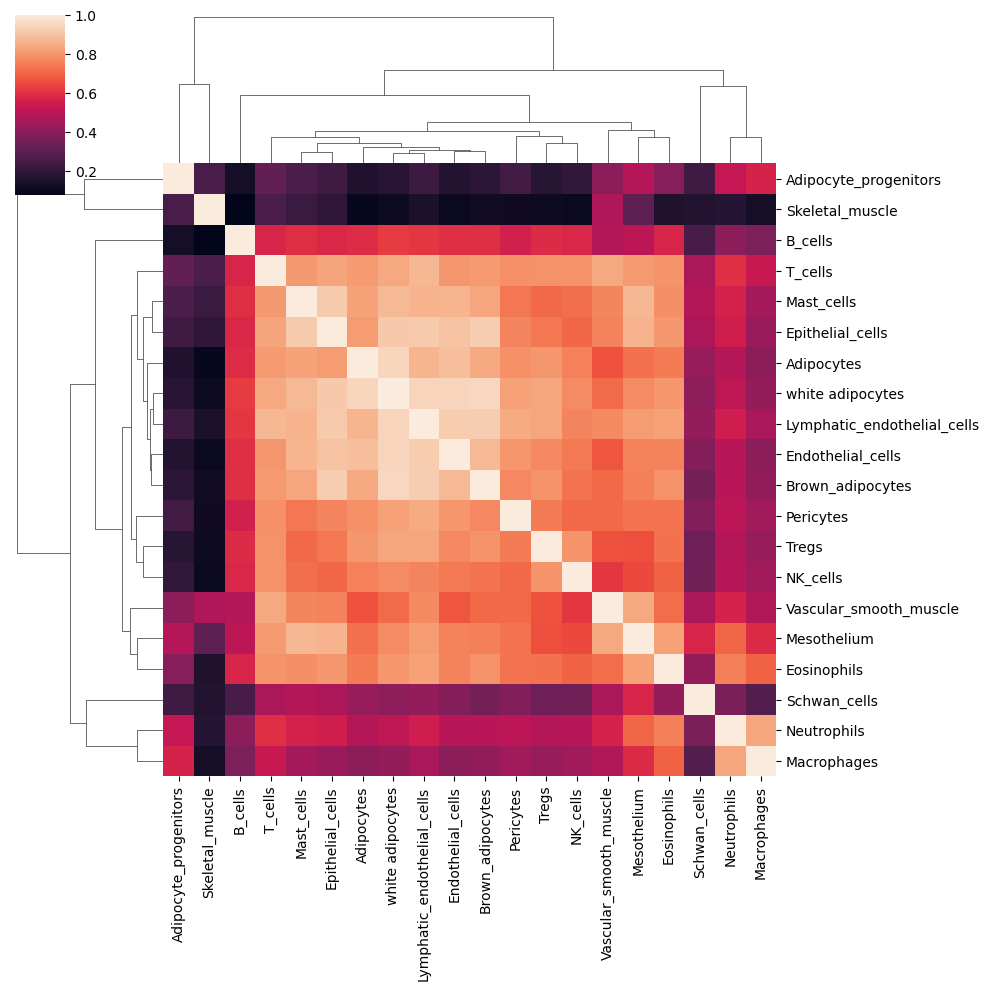

In [15]:
sns.clustermap(rsquared_dfs['count-A1'])

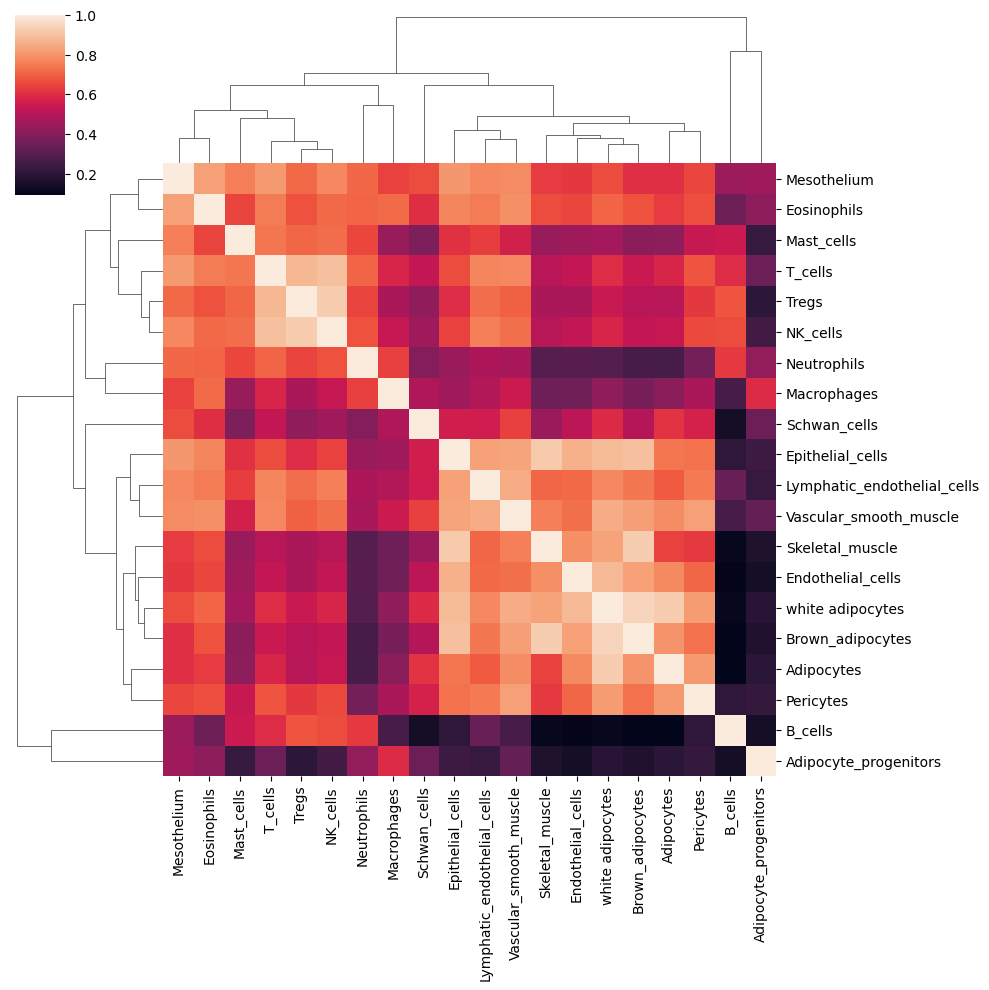

In [16]:
sns.clustermap(rsquared_dfs['count-B1'])

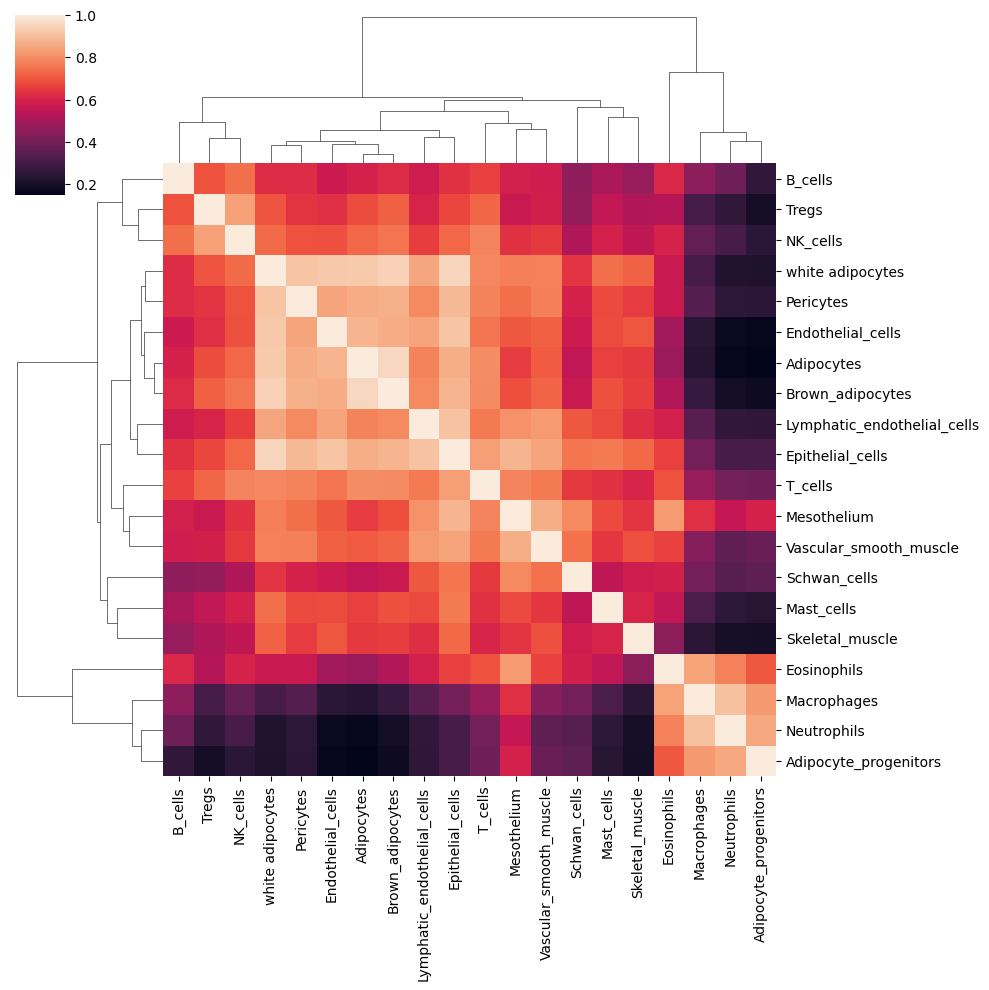

In [17]:
sns.clustermap(rsquared_dfs['count-C1'])

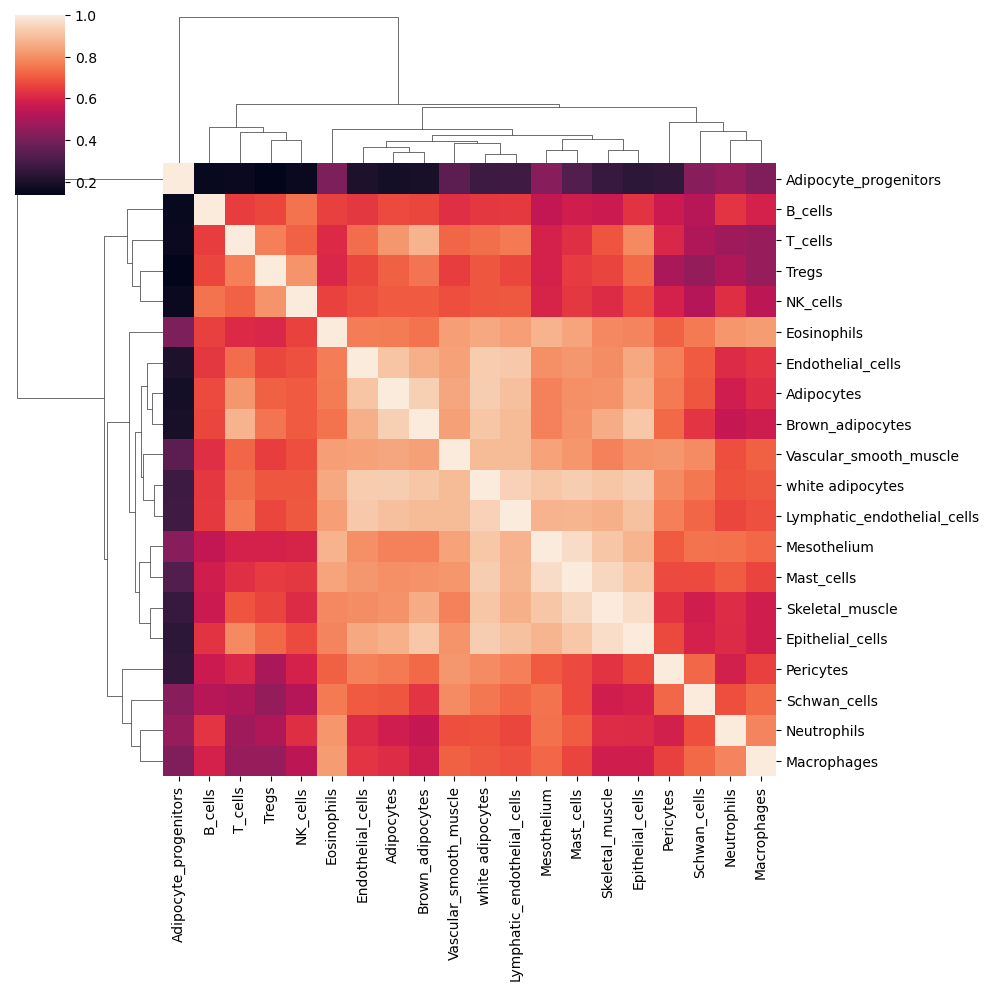

In [18]:
sns.clustermap(rsquared_dfs['count-D1'])

In [19]:
## combined slides analysis
combined_hex_avg_exp = pd.concat([hex_avg_exp['count-A1'][0], hex_avg_exp['count-B1'][0], hex_avg_exp['count-C1'][0], hex_avg_exp['count-D1'][0]]).reset_index(drop = True)
combined_weights = hex_avg_exp['count-A1'][1] + hex_avg_exp['count-B1'][1] + hex_avg_exp['count-C1'][1] + hex_avg_exp['count-D1'][1]

combined_rsquared_df = getrsquared(combined_hex_avg_exp, combined_weights)


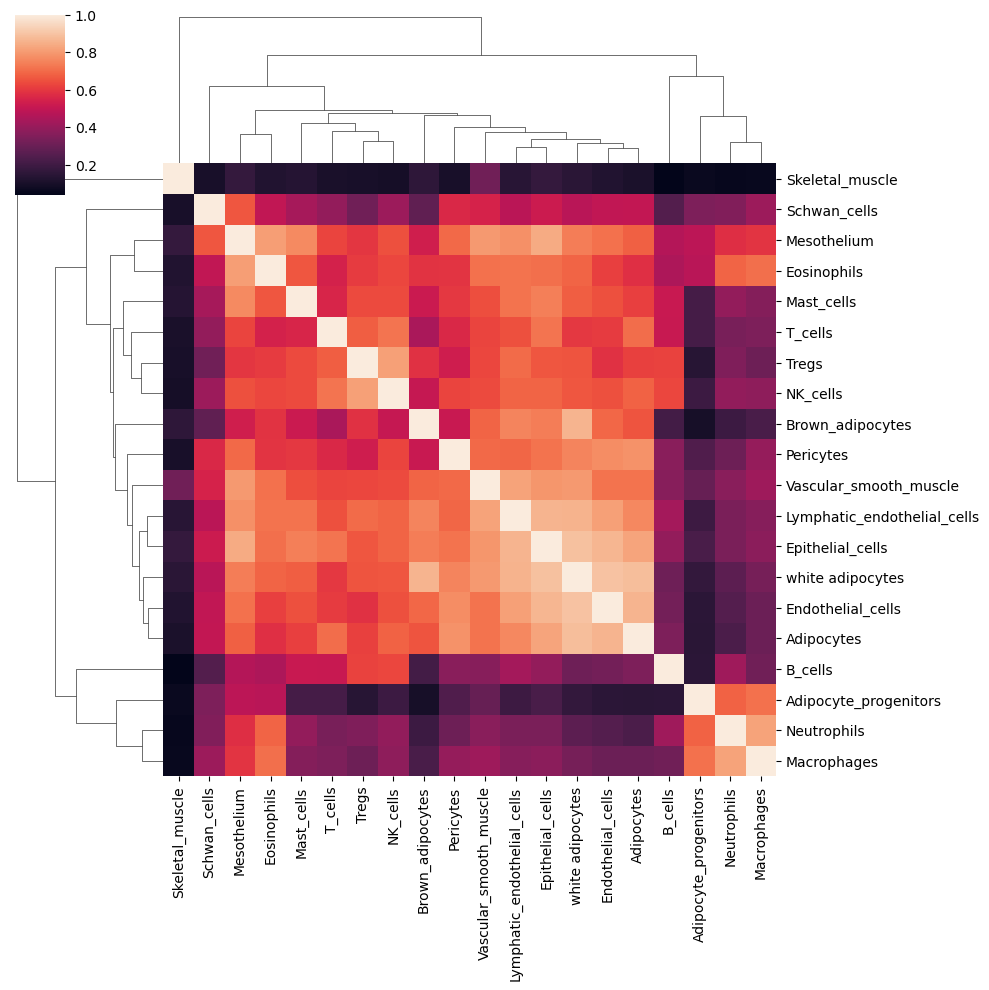

In [20]:
sns.clustermap(combined_rsquared_df)

### Showing the honeycomb units

In [28]:
## color the neighbors
adata_vis_neighbors_colored = adata_vis.copy()
adata_vis_neighbors_colored.obs['binary'] = 0
counter = 0
binary_idx = adata_vis_neighbors_colored.obs.columns.get_loc('binary')

for neighbor_idx, neighbor_data in enumerate(neighbors):
            indexes = []
            counter += 1
            for idx in range(0,7):
                tmp = np.where((adata_vis_neighbors_colored.obs['array_col'] == neighbor_data[idx][1]) & (adata_vis_neighbors_colored.obs['array_row'] == neighbor_data[idx][0]))[0]
                if len(tmp) > 0:
                    for item in tmp.tolist():
                        indexes.append(item)
                if counter %2 == 0:
                    adata_vis_neighbors_colored.obs.iloc[indexes, binary_idx] = 0.5
                if counter %2 == 1:
                    adata_vis_neighbors_colored.obs.iloc[indexes, binary_idx] = 1

In [26]:
## color the centers
adata_vis_centers_colored = adata_vis.copy()
adata_vis_centers_colored.obs['binary'] = 0
counter = 0
binary_idx = adata_vis_centers_colored.obs.columns.get_loc('binary')
center_idx = 0

for neighbor_idx, neighbor_data in enumerate(neighbors):
            indexes = []
            counter += 1
            indexes = np.where((adata_vis_centers_colored.obs['array_col'] == neighbor_data[center_idx][1]) & (adata_vis_centers_colored.obs['array_row'] == neighbor_data[center_idx][0]))[0].tolist()
            if counter %2 == 0:
                adata_vis_centers_colored.obs.iloc[indexes, binary_idx] = 0.5
            if counter %2 == 1:
                adata_vis_centers_colored.obs.iloc[indexes, binary_idx] = 1

In [16]:
import matplotlib.pyplot as plt
def select_slide(adata, s, batch_key="sample"):
    r"""This function selects the data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial experiments
    :param s: name of selected experiment
    :param batch_key: column in adata.obs listing experiment name for each location
    """

    slide = adata[adata.obs[batch_key].isin([s]), :].copy()
    s_keys = list(slide.uns["spatial"].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns["spatial"] = {s_spatial: slide.uns["spatial"][s_spatial]}

    return slide

axes: [[<Axes: > <Axes: >]
 [<Axes: > <Axes: >]]


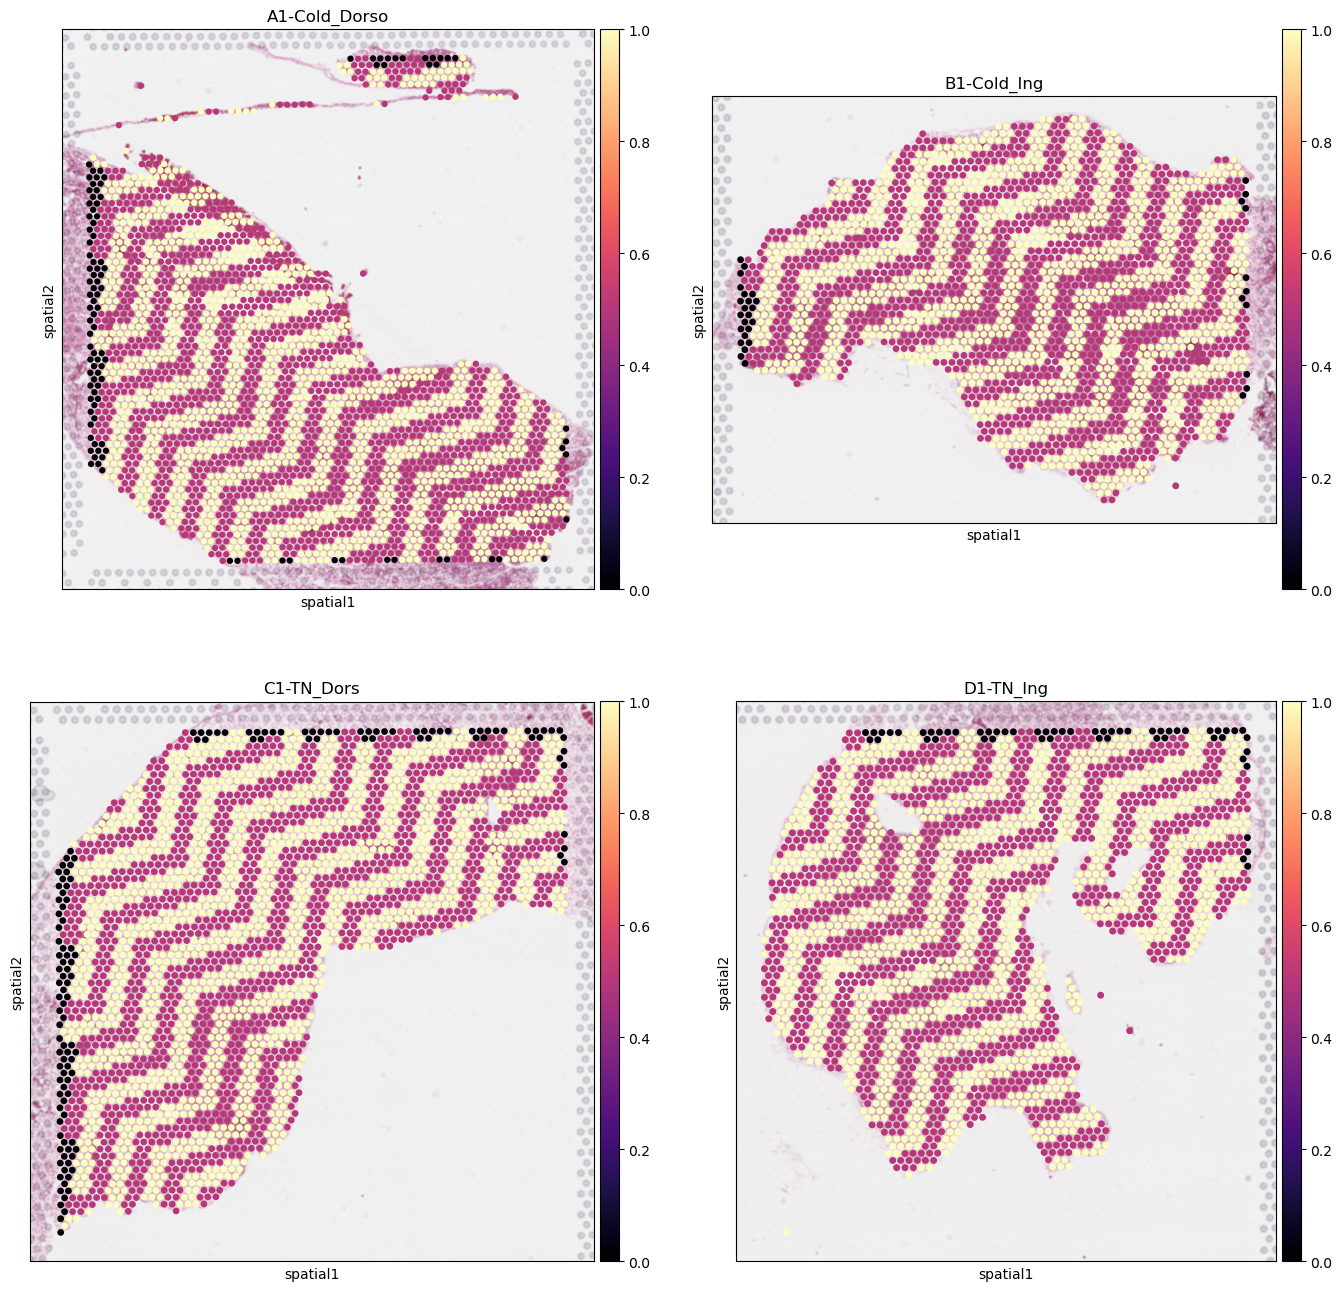

In [52]:
## Plot neighbors
# Define matplotlib Axes
# Number of Axes & plot size

slide_A1 = select_slide(adata_vis_neighbors_colored, 'count-A1')
slide_B1 = select_slide(adata_vis_neighbors_colored, 'count-B1')
slide_C1 = select_slide(adata_vis_neighbors_colored, 'count-C1')
slide_D1 = select_slide(adata_vis_neighbors_colored, 'count-D1')

ncols=2
nrows=2
figsize=8
wspace=0.1
fig,axs = plt.subplots(nrows=nrows, ncols=ncols,
                       figsize=(ncols*figsize+figsize*wspace*(ncols-1),nrows*figsize))
plt.subplots_adjust(wspace=wspace)
# This produces two Axes objects in a single Figure
print('axes:',axs)

# We can use these Axes objects individually to plot on them
# We need to set show=False so that the Figure is not displayed before we 
# finished plotting on all Axes and making all plot adjustments
sc.pl.spatial(slide_A1, cmap='magma', color='binary', size=1.3, img_key='hires', vmin=0, vmax=1, library_id='count-A1', show = False, ax=axs[0,0], title='A1-Cold_Dorso')
sc.pl.spatial(slide_B1, cmap='magma', color='binary', size=1.3, img_key='hires', vmin=0, vmax=1, library_id='count-B1', show = False, ax=axs[0,1], title='B1-Cold_Ing')
sc.pl.spatial(slide_C1, cmap='magma', color='binary', size=1.3, img_key='hires', vmin=0, vmax=1, library_id='count-C1', show = False, ax=axs[1,0], title='C1-TN_Dors')
sc.pl.spatial(slide_D1, cmap='magma', color='binary', size=1.3, img_key='hires', vmin=0, vmax=1, library_id='count-D1', ax=axs[1,1], title='D1-TN_Ing')


axes: [[<Axes: > <Axes: >]
 [<Axes: > <Axes: >]]


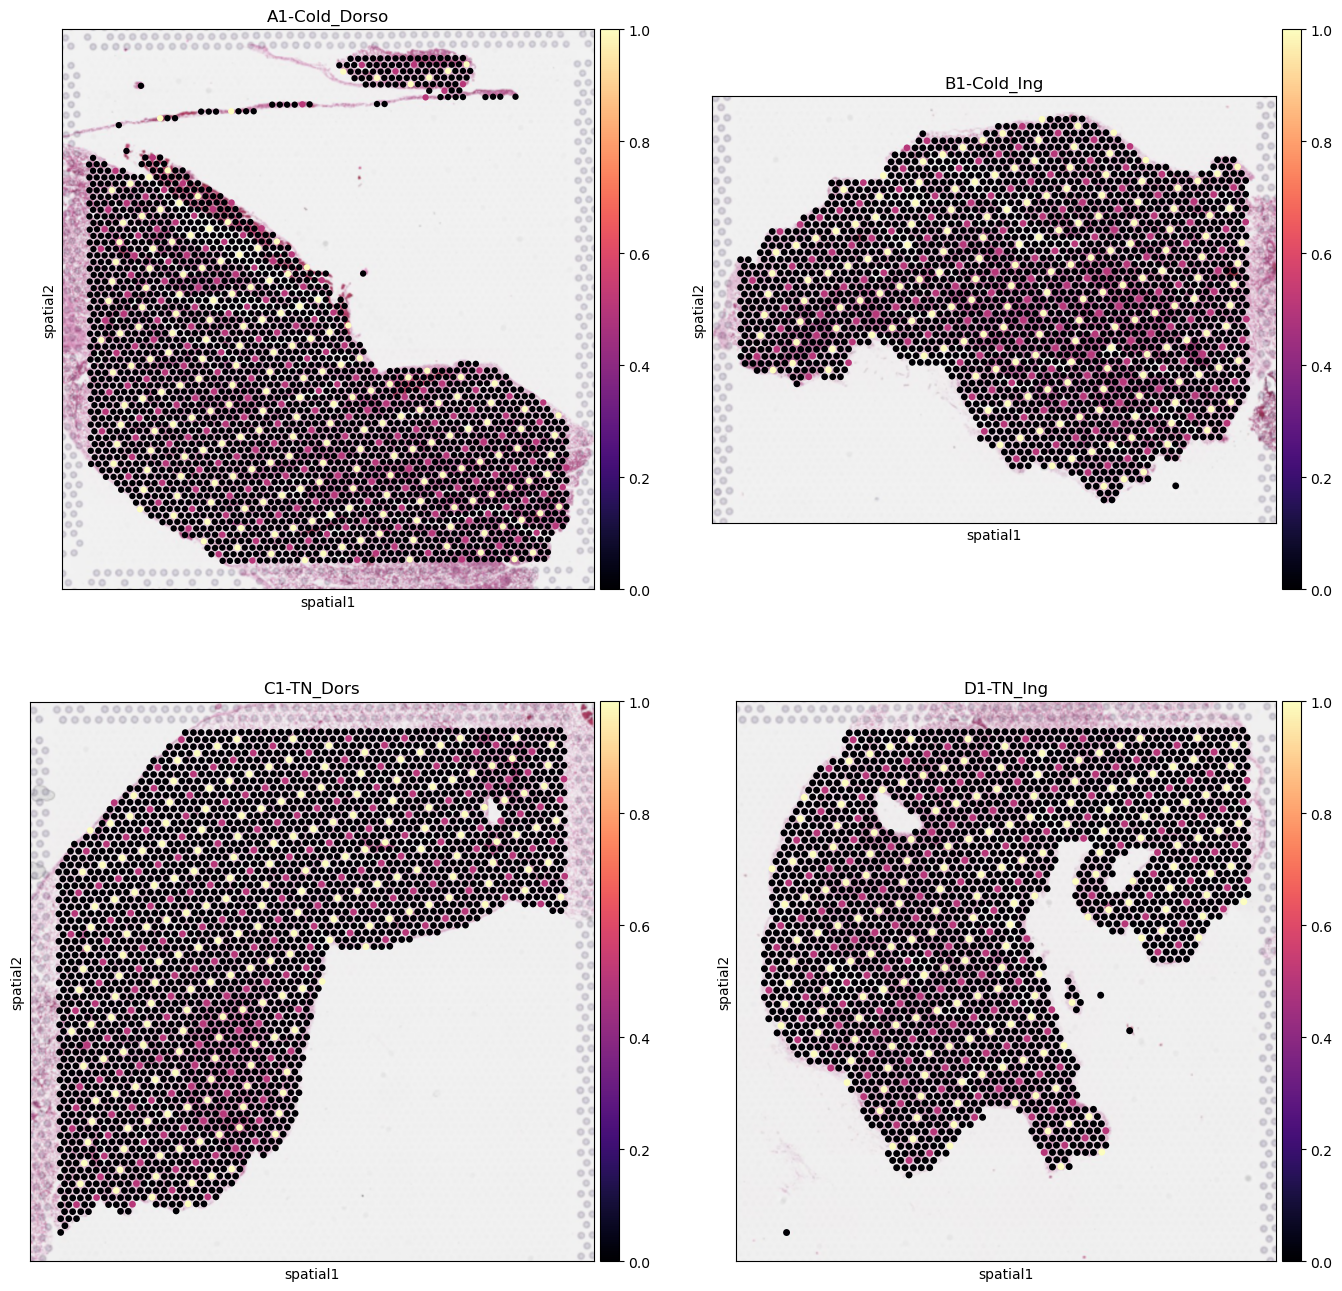

In [51]:
## Plot centers
# Define matplotlib Axes
# Number of Axes & plot size

slide_A1 = select_slide(adata_vis_centers_colored, 'count-A1')
slide_B1 = select_slide(adata_vis_centers_colored, 'count-B1')
slide_C1 = select_slide(adata_vis_centers_colored, 'count-C1')
slide_D1 = select_slide(adata_vis_centers_colored, 'count-D1')

ncols=2
nrows=2
figsize=8
wspace=0.1
fig,axs = plt.subplots(nrows=nrows, ncols=ncols,
                       figsize=(ncols*figsize+figsize*wspace*(ncols-1),nrows*figsize))
plt.subplots_adjust(wspace=wspace)
# This produces two Axes objects in a single Figure
print('axes:',axs)

# We can use these Axes objects individually to plot on them
# We need to set show=False so that the Figure is not displayed before we 
# finished plotting on all Axes and making all plot adjustments
sc.pl.spatial(slide_A1, cmap='magma', color='binary', size=1.3, img_key='hires', vmin=0, vmax=1, library_id='count-A1', show = False, ax=axs[0,0], title='A1-Cold_Dorso')
sc.pl.spatial(slide_B1, cmap='magma', color='binary', size=1.3, img_key='hires', vmin=0, vmax=1, library_id='count-B1', show = False, ax=axs[0,1], title='B1-Cold_Ing')
sc.pl.spatial(slide_C1, cmap='magma', color='binary', size=1.3, img_key='hires', vmin=0, vmax=1, library_id='count-C1', show = False, ax=axs[1,0], title='C1-TN_Dors')
sc.pl.spatial(slide_D1, cmap='magma', color='binary', size=1.3, img_key='hires', vmin=0, vmax=1, library_id='count-D1', ax=axs[1,1], title='D1-TN_Ing')



## Tetris grid ||>